## Creates the `lahinch_surf` feature view, trains the `cjsurf_model`

This training pipeline can be in Google Colab or a Jupyter notebook.

### Requirements

 * hopsworks

In [1]:
#!pip install -U hopsworks

In [2]:
import hopsworks
from sklearn.neighbors import KNeighborsClassifier
import hsfs
import numpy as np
import joblib
import os

### Not app.hopsworks.ai ?

If you are running your own Hopsworks cluster (not app.hopsworks.ai):

 * uncomment the cell below
 * fill in details for your cluster
 * run the cel

In [3]:
# Uncomment this cell and fill in details if you are running your own Hopsworks cluster
#!echo "xxxx" > api-key.txt
# key=""
# with open("api-key.txt", "r") as f:
#     key = f.read().rstrip()
# os.environ['HOPSWORKS_PROJECT']="cjsurf"
# os.environ['HOPSWORKS_HOST']="35.187.178.84"
# os.environ['HOPSWORKS_API_KEY']=key

### Connect to your Hopsworks cluster

If you only set the HOPSWORKS_API_KEY, it will assume you are connecting to app.hopsworks.ai.
Set HOPSWORKS_HOST and HOPSWORKS_PROJECT environment variables to connect to a different Hopsworks cluster.

In [4]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/398
Connected. Call `.close()` to terminate connection gracefully.


### Online Transformations for input features

Normalize the numerical input features (`height`, `period`, `direction`) with HSFS built-in `standard_scalar`.

In [5]:
hours=119

standard_scaler = fs.get_transformation_function(name="standard_scaler")

transformation_functions = {
    "height": standard_scaler,
    "period": standard_scaler,
    "direction": standard_scaler,
}
for i in range(1,hours):
    transformation_functions["height" + str(i*2)]=standard_scaler
    transformation_functions["period" + str(i*2)]=standard_scaler
    transformation_functions["direction" + str(i*2)]=standard_scaler    

## Select features for the Feature View

Join the `wave_height` from `lahinch` feature group with all of the features from the `swells_exploded` feature group. 

The `query` object can be inspected - `show` rows, `read` to get a DataFrame.

In [6]:
lahinch_fg = fs.get_feature_group("lahinch", version=1)
swells_fg = fs.get_feature_group("swells_exploded", version=1)
query = lahinch_fg.select(['wave_height']).join(
    swells_fg.select_except(['beach_id'])) 

### Get or create the `lahinch_surf` feature view

In [7]:
version=1
try: 
    fv = fs.get_feature_view("lahinch_surf", version=version)
except:
    fv = fs.create_feature_view(name='lahinch_surf', 
                            description="Lahinch surf height prediction features",
                            version=version,
                            labels=["wave_height"],
                            query=query)

In [8]:
#X_train,y_train,X_test,y_test = fv.train_test_split(0.1)

### Read your Training Data as Pandas DataFrames
You can read back the training data as Pandas Dataframes - here split into train/test sets, with `X_` storing the features and `y_` the labels.

In [9]:
X_train, y_train, X_test, y_test = fv.train_test_split(test_size=0.1)

2022-08-21 16:34:14,919 INFO: USE `dowlingj_featurestore`
2022-08-21 16:34:16,247 INFO: WITH right_fg0 AS (SELECT *
FROM (SELECT `fg1`.`wave_height` `wave_height`, `fg1`.`beach_id` `join_pk_beach_id`, `fg1`.`observation_time` `join_evt_observation_time`, `fg0`.`pred_dtime` `pred_dtime`, `fg0`.`height` `height`, `fg0`.`period` `period`, `fg0`.`direction` `direction`, RANK() OVER (PARTITION BY `fg1`.`beach_id`, `fg1`.`observation_time` ORDER BY `fg0`.`hits_at` DESC) pit_rank_hopsworks
FROM `dowlingj_featurestore`.`lahinch_1` `fg1`
INNER JOIN `dowlingj_featurestore`.`swells_exploded_1` `fg0` ON `fg1`.`beach_id` = `fg0`.`beach_id` AND `fg1`.`observation_time` >= `fg0`.`hits_at`) NA
WHERE `pit_rank_hopsworks` = 1) (SELECT `right_fg0`.`wave_height` `wave_height`, `right_fg0`.`pred_dtime` `pred_dtime`, `right_fg0`.`height` `height`, `right_fg0`.`period` `period`, `right_fg0`.`direction` `direction`
FROM right_fg0)


Not all of the features are needed for training - only the height, period, direction of the swells with a `hits_at` timestamp that is closest to, but before the observation of the `surf_height`.

In [10]:
X_train = X_train[['height', 'period', 'direction']]
X_test = X_test[['height', 'period', 'direction']]
X_train

,height,period,direction
1,9.0,15.0,85
2,9.7,13.5,91
4,4.4,9.7,104
5,4.3,12.9,95
6,2.7,12.5,81
...,...,...,...
344,0.5,6.9,55
345,2.5,11.5,60
346,3.1,10.8,57
347,2.8,11.2,65


Encode the label (`wave_height`) in both the train and test DataFrames

In [11]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train_encoded=le.fit_transform(y_train['wave_height'])
y_test_encoded=le.fit_transform(y_test['wave_height'])

## Train the model
Using k-nearest neighbors in Scikit-Learn

In [12]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train,y_train_encoded)

KNeighborsClassifier(n_neighbors=3)

### Evaluate the Model

On our test set, calculate the classification scores: precision, recall, fscore.
It may also be useful to calculate the rmse to see how close all the predictions were to the true wave_heights.

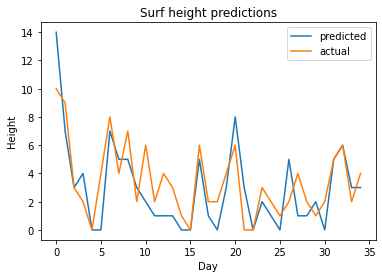

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, mean_squared_error
%matplotlib inline

y_pred = model.predict(X_test)

precision, recall, fscore, _ = precision_recall_fscore_support(
    y_test_encoded, y_pred, average="weighted", zero_division=1)

rmse = mean_squared_error(y_test_encoded, y_pred)

# We model surf height prediction as a classification problem, as there
# only a small number of heights reported on Lahinch beach, but the RMSE
# is still a useful metric for evaluating if your model is more accurate or not
metrics = {
    "precision" : precision,
    "recall" : recall,
    "fscore" : fscore,
    "rmse" : rmse
}

error_rates = []
num_samples=len(y_pred)
for a in range(1, num_samples):
    error_rates.append(np.mean(y_test_encoded[a] - y_pred))

plt.plot(range(0,num_samples), y_pred, label="predicted")
plt.plot(range(0,num_samples), y_test_encoded, label="actual")
plt.title('Surf height predictions')
plt.xlabel('Day')
plt.ylabel('Height')
plt.legend()
plt.show()

## Register the model with Hopsworks Model Registry

The model registry stores your model for later use in inference.

Here, we also specify the model input/output schema using the DataFrame containing the training features.
We also send a dict containing the `metrics` computed in the last cell, as these will be shown for the model in the registry. 

We can also include a sample to enable a deployed model to be easily tested in the UI. The sample will be stored in the model registry, and when you create a deployment with the model, there is a `Test Model` UI button which will send that sample to the model for scoring, returning the result. It is useful for debugging models.

Here, we are creating a `mr.python` model for Scikit-Learn. There is also a `mr.tf` model available for TensorFlow models.
When you call `save()` on the model returned by HSML, it uploads the model and any artifacts to Hopsworks.


In [14]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

project = hopsworks.login()

mr = project.get_model_registry()
joblib.dump(model, 'knn_model.pkl')

input_example = X_train.sample()
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

knn_model = mr.python.create_model(
    version=1,
    name="cjsurf_model", 
    metrics=metrics,
    model_schema=model_schema,
    input_example=input_example, description="Lahinch Surf height predictions")

knn_model.save("knn_model.pkl")

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/398
Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/398/models/cjsurf_model/1


Model(name: 'cjsurf_model', version: 1)